In [1]:
from typing import List

import torch
import torch.cuda
from torch.utils.data import DataLoader
from typing import Union
from datetime import datetime

from PIL import Image as PILImage

import numpy as np
import pyml
from models import DiscriminatorPixelMse, DownSampler, GeneratorESPCN, DiscriminatorVggMse

In [2]:
torch.cuda.is_available()

True

In [3]:
dataset = pyml.ImagesDataset.from_dirs_recursive(roots=["datasets/flowers102processed"], channels_order='chw')
batch_size = 16

if torch.cuda.is_available():
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, pin_memory_device='cuda')
else:
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
class GanHelper:
    def __init__(self, data_loader: DataLoader):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.data_loader = data_loader
        scale = 4
        self.generator = GeneratorESPCN(channels=128, upscale=scale).to(self.device)

        self.d_pixel_mse = DiscriminatorPixelMse(weight=1.0)
        self.d_vgg_mse = DiscriminatorVggMse(weight=0.0001, inpad_size=16).to(self.device)
        self.d_vgg_mse_x2 = DiscriminatorVggMse(weight=0.0001, prescale=2, inpad_size=16).to(self.device)

        self.downsampler = DownSampler(scale=scale).to(self.device)

        self.losses = []
        self.losses_print_step = 50

    def add_loss(self, losses: List[torch.Tensor]):
        self.losses.append([loss.item() for loss in losses])
        if self.losses_print_step is not None and len(self.losses) % self.losses_print_step == 0:
            av_loss = np.average(np.array(self.losses[-self.losses_print_step:]), axis=0)
            print(f"{len(self.losses)}: {av_loss}")

    def train(self, steps: int, lr: float):
        generator_optimizer = torch.optim.Adam([
            {'params': self.generator.layers.parameters()},
            {'params': self.generator.pixel_shuffle.parameters(), 'lr': lr * 0.1}
        ], lr=lr)
        self.generator.train()

        step = 0
        while True:
            for label in self.data_loader:
                label = label.to(self.device)
                x = self.downsampler(label)

                generator_optimizer.zero_grad()
                y = self.generator(x)

                losses = [f.loss(y, label) for f in [self.d_pixel_mse, self.d_vgg_mse, self.d_vgg_mse_x2]]
                loss = sum(losses)
                loss.backward()
                generator_optimizer.step()

                self.add_loss(losses)

                step += 1
                if step >= steps:
                    return

    def demonstrate(self, label: Union[np.ndarray, torch.Tensor]) -> PILImage:
        if isinstance(label, np.ndarray):
            if len(label.shape) == 3:
                label = label[np.newaxis]
            label = torch.from_numpy(label)
        assert isinstance(label, torch.Tensor)
        label = label.to(self.device)

        self.generator.eval()
        x = self.downsampler(label)
        y = self.generator(x)
        x4x = self.downsampler.upsample(x)

        triple = torch.cat([x4x, y, label], dim=3)
        pic = triple.cpu().detach().numpy()[0]
        pic = np.moveaxis(pic, 0, 2)
        pic = np.clip(pic, 0.0, 1.0)
        img = PILImage.fromarray((pic * 255.0).astype(np.uint8))
        return img

    def save_model(self) -> str:
        suffix = datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
        torch.save(self.generator.state_dict(), f"models/espcn/generator_espcn_{suffix}.pth")
        return suffix

    def load_model(self, suffix: str):
        self.generator.load_state_dict(torch.load(f"models/espcn/generator_espcn_{suffix}.pth"))

In [5]:
gan_helper = GanHelper(data_loader)

/home/lgor/projects/2023/pyenv310/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [6]:
gan_helper.train(steps=5 * len(dataset) // batch_size, lr=0.001)

50: [0.04826851 0.01973219 0.02156287]
100: [0.01131003 0.01510745 0.01561375]
150: [0.00872793 0.01385311 0.01245531]
200: [0.00669205 0.01140856 0.00889931]
250: [0.00554774 0.00996801 0.00695209]
300: [0.0053931  0.01037034 0.00707328]


In [7]:
gan_helper.train(steps=30 * len(dataset) // batch_size, lr=0.0003)

350: [0.00452088 0.00871277 0.00556791]
400: [0.00406815 0.00798334 0.00509208]
450: [0.00394451 0.00771653 0.00496873]
500: [0.00365662 0.00725203 0.00468389]
550: [0.00362973 0.00763887 0.0047584 ]
600: [0.0036266  0.00728981 0.0046865 ]
650: [0.00340846 0.00703839 0.00452584]
700: [0.00355955 0.00776363 0.00482775]
750: [0.00344561 0.0074977  0.00475496]
800: [0.00334101 0.00692292 0.00443269]
850: [0.00323703 0.00680964 0.00434997]
900: [0.00325401 0.00682    0.00434395]
950: [0.00318025 0.00678598 0.00431889]
1000: [0.00320276 0.00679058 0.0042778 ]
1050: [0.00309969 0.00669476 0.00422946]
1100: [0.00318356 0.0067248  0.00425606]
1150: [0.00307756 0.00674197 0.00420628]
1200: [0.00309898 0.00675918 0.00417789]
1250: [0.00305696 0.00655662 0.00412891]
1300: [0.00299231 0.00657342 0.00414078]
1350: [0.00299989 0.00660297 0.00409466]
1400: [0.00301945 0.00667584 0.00414769]
1450: [0.00296149 0.00642862 0.00406191]
1500: [0.00282131 0.00635952 0.00392092]
1550: [0.00308503 0.00689134 

In [8]:
gan_helper.train(steps=50 * len(dataset) // batch_size, lr=0.0001)

2250: [0.00266517 0.0061635  0.00364807]
2300: [0.00275526 0.00612241 0.00366191]
2350: [0.00267109 0.00602943 0.00360877]
2400: [0.0027213  0.00607943 0.00367041]
2450: [0.00269537 0.006097   0.00363246]
2500: [0.00268344 0.00605678 0.00360078]
2550: [0.00262327 0.00594855 0.00356355]
2600: [0.00262373 0.00599485 0.00355882]
2650: [0.00270652 0.0060075  0.00354383]
2700: [0.00262851 0.00603989 0.00354791]
2750: [0.00263678 0.00599998 0.00352415]
2800: [0.00260796 0.00593506 0.00349864]
2850: [0.00259916 0.00595049 0.00348759]
2900: [0.00267042 0.00602443 0.00353601]
2950: [0.00262787 0.00597623 0.00351988]
3000: [0.00257558 0.00593379 0.00347809]
3050: [0.0025564  0.00589159 0.0034457 ]
3100: [0.00259541 0.00592179 0.00346126]
3150: [0.0026103  0.00589905 0.00342236]
3200: [0.00258824 0.00592649 0.00348485]
3250: [0.00256955 0.00587602 0.00341677]
3300: [0.00257967 0.00592378 0.00343883]
3350: [0.00255954 0.00582885 0.00335609]
3400: [0.00257448 0.0059311  0.00344893]
3450: [0.0025119

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


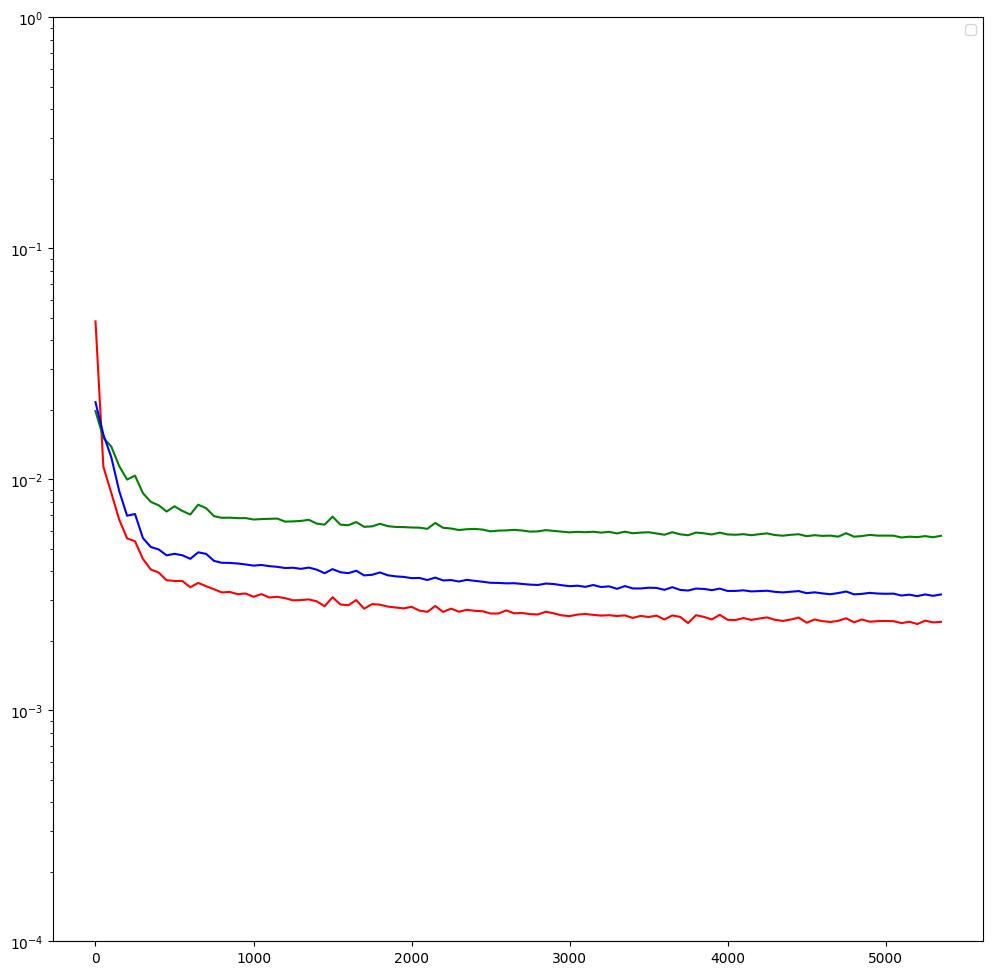

In [9]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.set_ylim(0.0001, 1)

def my_plot(lst: List[float], av: int):
    for i, color in enumerate(["red", "green", "blue"]):
        arr = np.array(lst)[:, i]
        arr = arr[:arr.shape[0] // av * av]
        arr = arr.reshape(-1, av).mean(axis=1)
        ax.plot([i * av for i in range(arr.shape[0])], arr, c=color)

my_plot(gan_helper.losses, av=50)

ax.legend()
plt.show()

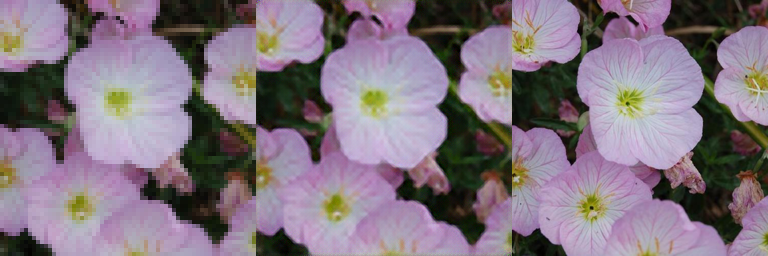

In [10]:
gan_helper.demonstrate(dataset[0])

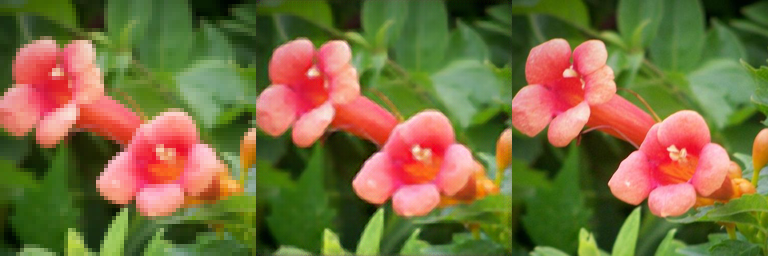

In [11]:
gan_helper.demonstrate(dataset[6])

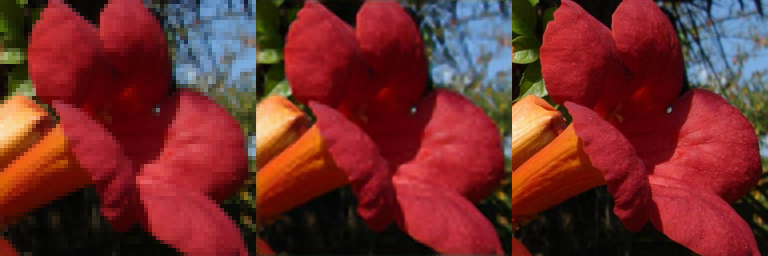

In [12]:
gan_helper.demonstrate(dataset[7])